### THIS SHIT WORKS.
##### Don't change it.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras import layers

INPUT_SIZE = 30
LEARNING_RATE = 0.001

input = layers.Input(shape=(INPUT_SIZE,))
x = layers.Dense(20, activation='relu')(input)
x = layers.Dense(10, activation='relu')(input)
x = layers.Dense(1, activation='tanh')(x)
F_curr_model = keras.Model(inputs=input, outputs=x)
F_prev_model = keras.Model(inputs=input, outputs=x)
F_curr_model.summary()

F_curr_model.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE), loss='mse')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [3]:
def gen_price_series(size=10000, k=3, a=0.9):
    p_series = np.ndarray((size,))
    b_series = np.ndarray((size,))
    p_series[0] = 0
    b_series[0] = 0

    for i in range(1, size):
        p_series[i] =  p_series[i - 1] + b_series[i - 1] + k * np.random.normal()
        b_series[i] = a * b_series[i - 1] + np.random.normal()

    R = np.max(p_series) - np.min(p_series)
    z_series = np.exp(p_series / R)

    return z_series

def calc_price_returns(zt):
    # returns the set rt, with the first element (0) being NaN
    rt = np.ndarray((zt.shape[0],))
    rt[0] = np.nan
    rt[1:] = zt[1:] - zt[:-1]
    return rt


def calc_return(mu, rt, Ft_curr, Ft_prev, rft=0, delta=0):
    '''Calculates the returns (Rt) on-line.'''

    return mu * (rft + Ft_prev * (rt - rft) - delta * tf.math.abs(Ft_curr - Ft_prev))

def calc_DSR(n, Rt, At_prev, Bt_prev):
    '''Calculates the differential Sharpe ratios (DSR, Dt) on-line.'''

    At_curr = At_prev + n * (Rt - At_prev)
    Bt_curr = Bt_prev + n * (Rt ** 2 - Bt_prev)

    dDt_dRt = (Bt_prev - At_prev * Rt) / ((Bt_prev - At_prev ** 2) ** 1.5)

    return dDt_dRt, At_curr, Bt_curr

In [4]:
def test_performance(zt, Ft):
    values = np.ones((zt.shape[0],))
    owned = False
    money = 1
    values[0] = money

    values_ideal = np.ones((zt.shape[0],))
    owned_ideal = False
    money_ideal = 1
    values_ideal[0] = money_ideal

    for t in range(INPUT_SIZE, SERIES_LENGTH - 1):

        # Model Ft
        if (Ft[t] > 0) and (not owned):
            # BUY
            owned = True
            money -= zt[t]
        elif (Ft[t] < 0) and owned:
            # SELL
            owned = False
            money += zt[t]
        
        # Ideal
        if (zt[t + 1] > zt[t]) and (not owned_ideal):
            # BUY
            owned_ideal = True
            money_ideal -= zt[t]
        elif (zt[t + 1] < zt[t]) and owned_ideal:
            # SELL
            owned_ideal = False
            money_ideal += zt[t]

        if owned:
            values[t] = money + zt[t]
        else:
            values[t] = money

        if owned_ideal:
            values_ideal[t] = money_ideal + zt[t]
        else:
            values_ideal[t] = money_ideal
    
    return (values[-1] / zt[-1], values_ideal[-1] / zt[-1]), (values, values_ideal)


In [5]:
# SERIES_LENGTH = 10000
# INPUT_SIZE = 10
# Ft = np.ones((SERIES_LENGTH,))
# zt = gen_price_series(size=SERIES_LENGTH, k=3, a=0.9)
# deltas, val_series = test_performance(zt, Ft)

# At = np.zeros((SERIES_LENGTH,))
# Bt = np.ones((SERIES_LENGTH,))
# DSR_series = np.ones((SERIES_LENGTH,))

# plt.plot(zt)
# plt.plot(val_series[0])
# plt.plot(val_series[1])

# a = val_series[1]

tf.Tensor([[0.63307667]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6485222]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6400914]], shape=(1, 1), dtype=float32)


C:\Users\jason\AppData\Local\Temp\ipykernel_2092\2916840510.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  SR_series[t] = np.mean(Rt_series[INPUT_SIZE:t]) / np.std(Rt_series[INPUT_SIZE:t])


tf.Tensor([[0.6331073]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6234017]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.62105983]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6129887]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6099387]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.626994]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6286807]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6586209]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.67407686]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.68723404]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.71309704]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7055258]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.70803994]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.69948685]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6999453]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7127894]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.70428187]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.70869315]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7080551

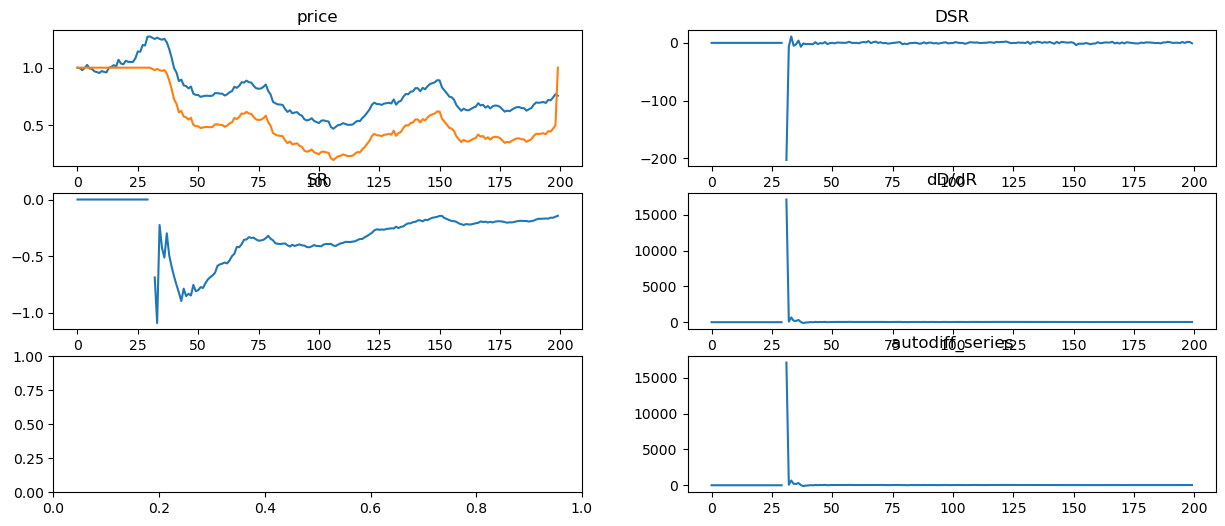

tf.Tensor([[0.77956516]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.77490205]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7710612]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7691611]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.76765007]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.76556915]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7621133]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.75923216]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7538588]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7488159]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7434432]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.737662]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.72718]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7222702]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.72034395]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.71431565]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7131633]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7088363]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.70345396]]

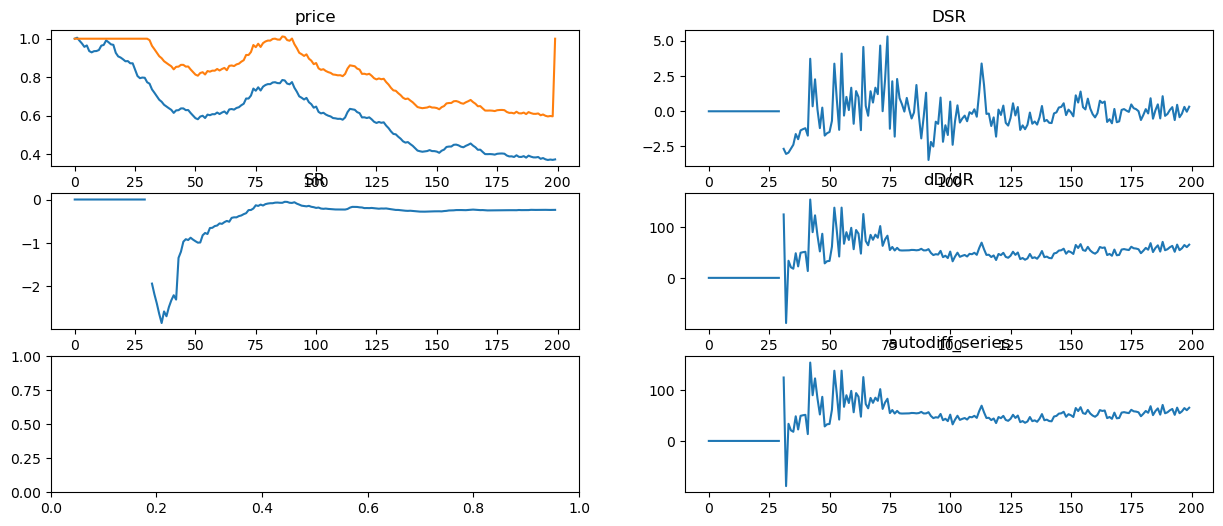

tf.Tensor([[0.762376]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.76317555]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7616367]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.76974344]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.768669]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.76592124]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7654496]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.76178473]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7557659]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.75376457]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.75130785]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7421719]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.745409]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.74825394]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.75106514]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7529733]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.75864893]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.76234174]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7653734

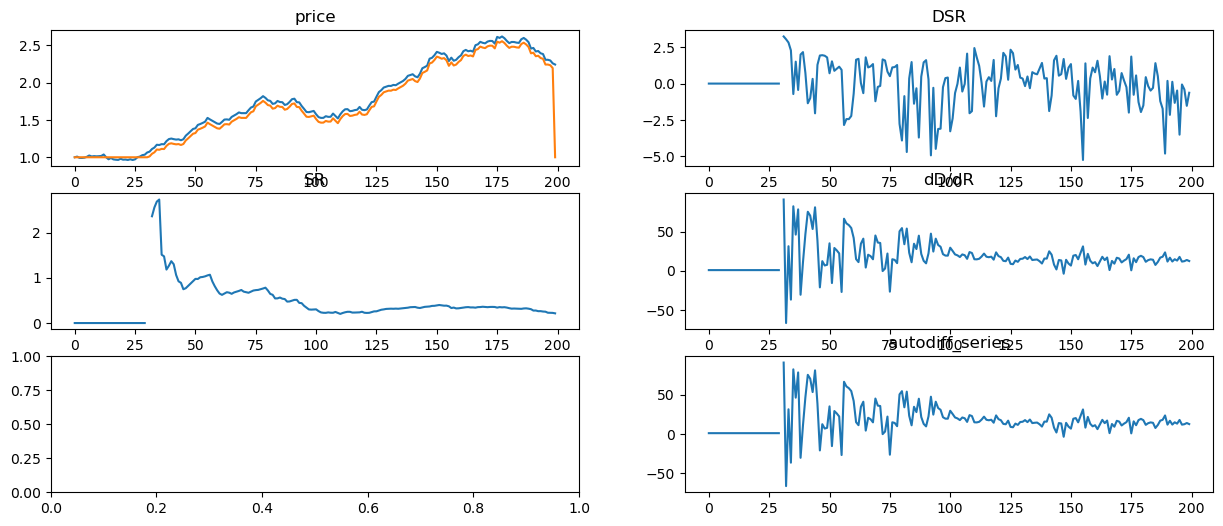

tf.Tensor([[0.76629144]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7741142]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.769311]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.77507275]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.778809]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.77453417]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7715378]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.775332]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7730435]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7701081]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.76768124]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7710809]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.77490765]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.77584743]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.777163]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7783211]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.77848256]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.77503806]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.769674]], 

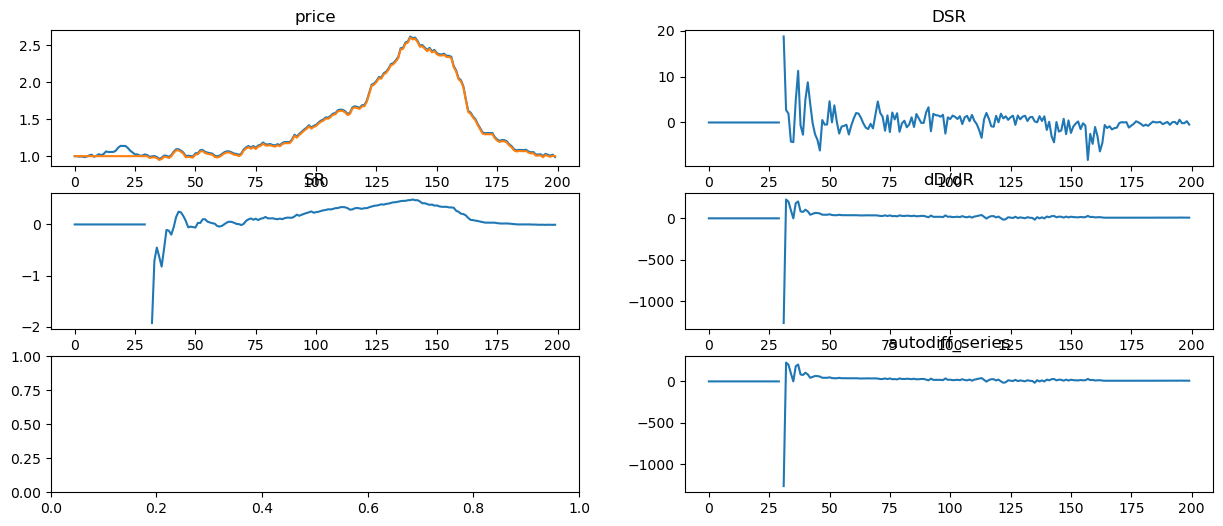

tf.Tensor([[0.4831431]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.48317927]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.48139545]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.47643596]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.47998363]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.4814382]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.4815501]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.47975016]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.4778513]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.48047575]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.47569078]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.48092252]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.48039666]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.47383285]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.47430715]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.47500366]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.47076288]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.4680471]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.4

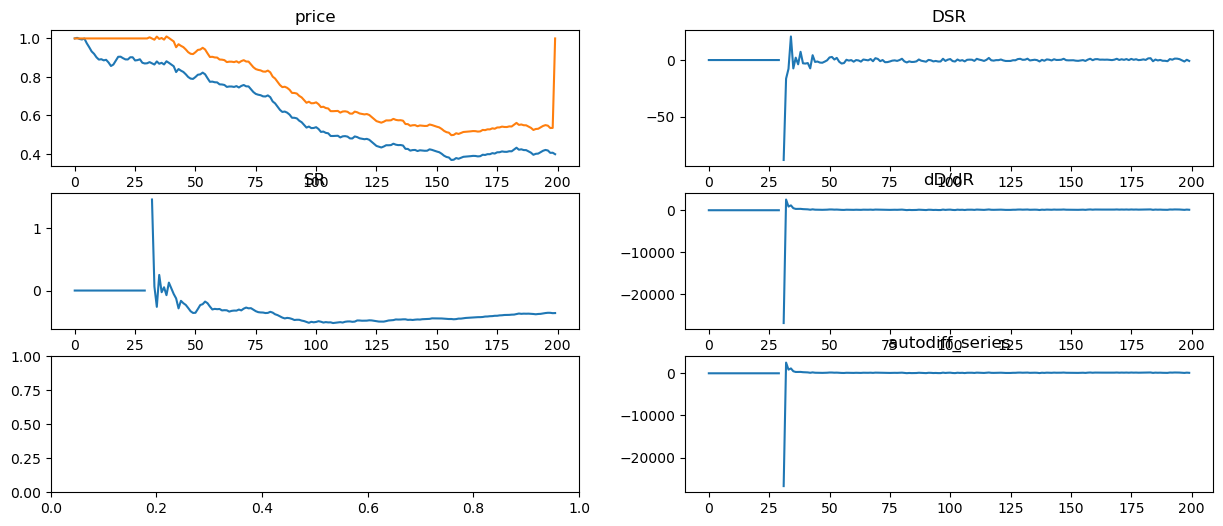

tf.Tensor([[0.47861674]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.48126134]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.47652724]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.47339126]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.46485597]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.46470857]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.46729648]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.46490356]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.46154472]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.4605548]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.45803618]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.45467344]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.45744246]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.45552456]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.44835725]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.4473693]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.44058326]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.43266052]], shape=(1, 1), dtype=float32)
tf.Tensor([[

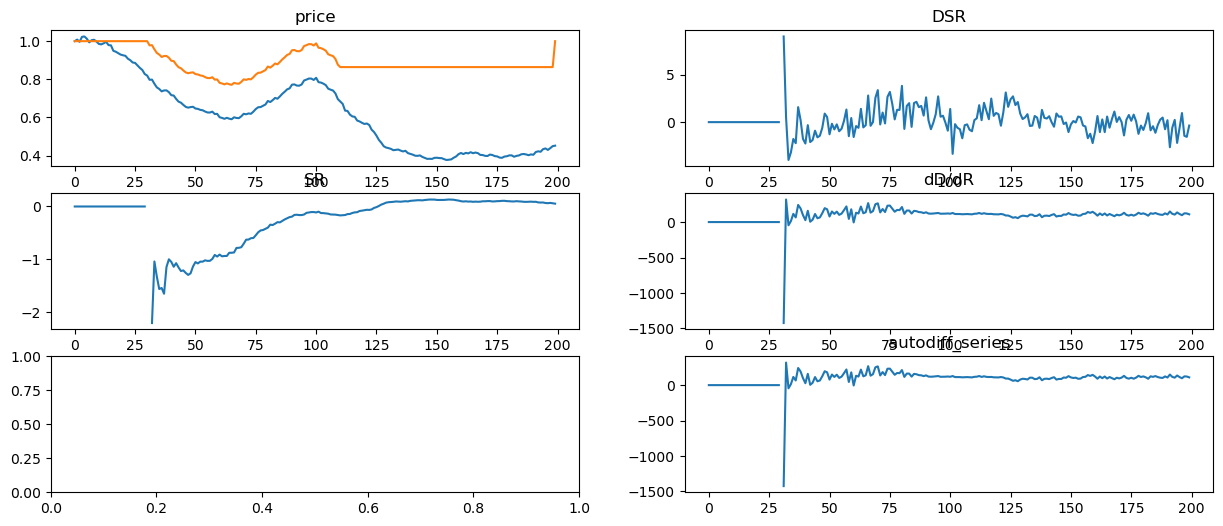

tf.Tensor([[-0.74793595]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.755185]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.7595295]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.7584506]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.76650554]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.7693126]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.76877415]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.77452236]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.77700955]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.7810127]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.78579825]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.7839051]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.78317314]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.78389895]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.7779662]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.76738334]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.7554512]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.7413634]], shape=(1, 1), dtype=float32)
tf

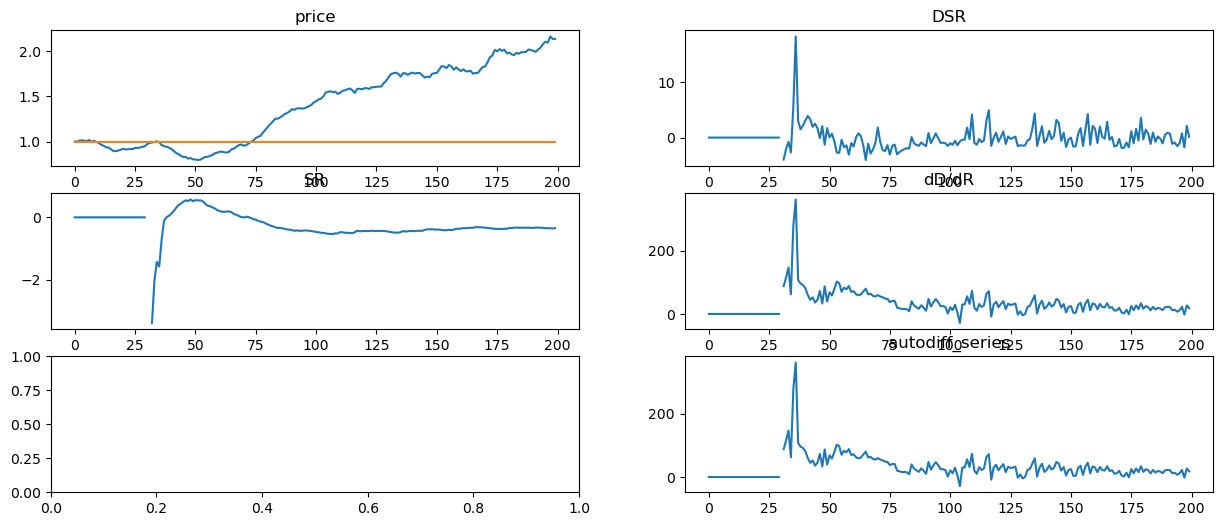

tf.Tensor([[-0.82080686]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.82047397]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8200044]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8215018]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8222865]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8217997]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8201478]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.81957597]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.82366693]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8225897]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8252418]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.82795054]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8299154]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8339274]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8349283]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.83479357]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.83994097]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8408946]], shape=(1, 1), dtype=float32)
tf.

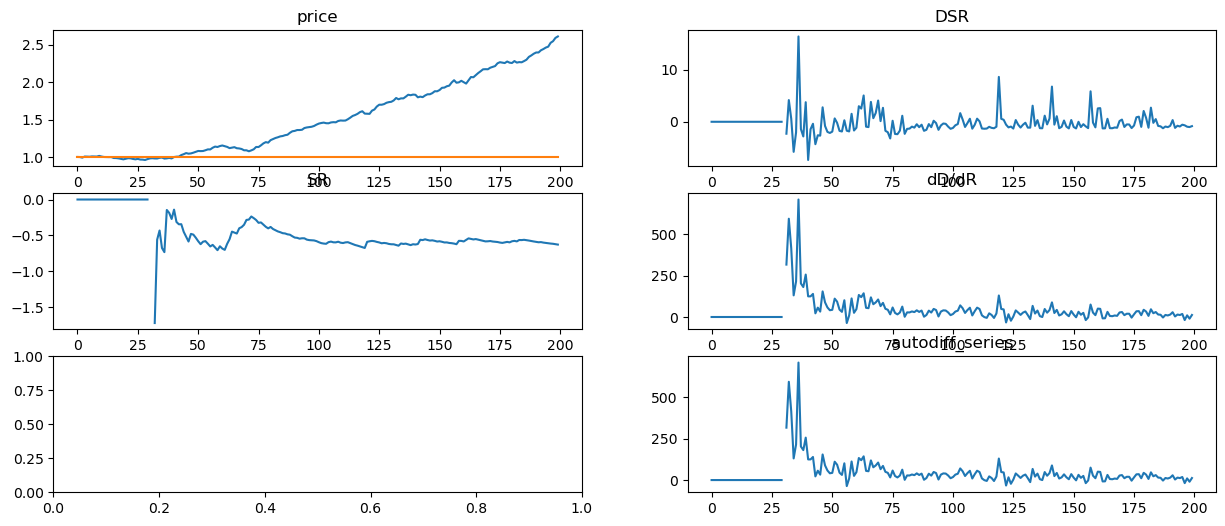

tf.Tensor([[-0.8547972]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.85661507]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8574454]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8541695]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8551253]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8552825]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8536802]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8585202]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8546531]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.85824156]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8577091]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.85083246]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.849221]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8463945]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.84366226]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8401661]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8377724]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.82714]], shape=(1, 1), dtype=float32)
tf.Tensor

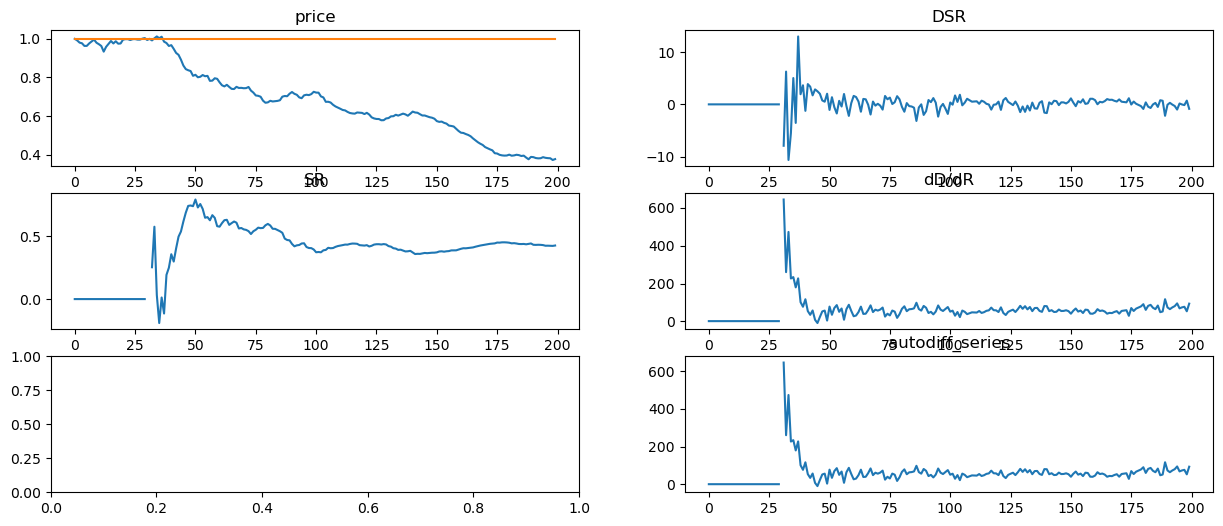

tf.Tensor([[-0.97783977]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9762941]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9737205]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.97497445]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.97593397]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.97672284]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9789942]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.97930753]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.97818667]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9804897]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.98262197]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9827136]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.98042953]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9778103]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.97340435]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9726705]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9698534]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.96592355]], shape=(1, 1), dtype=float32)


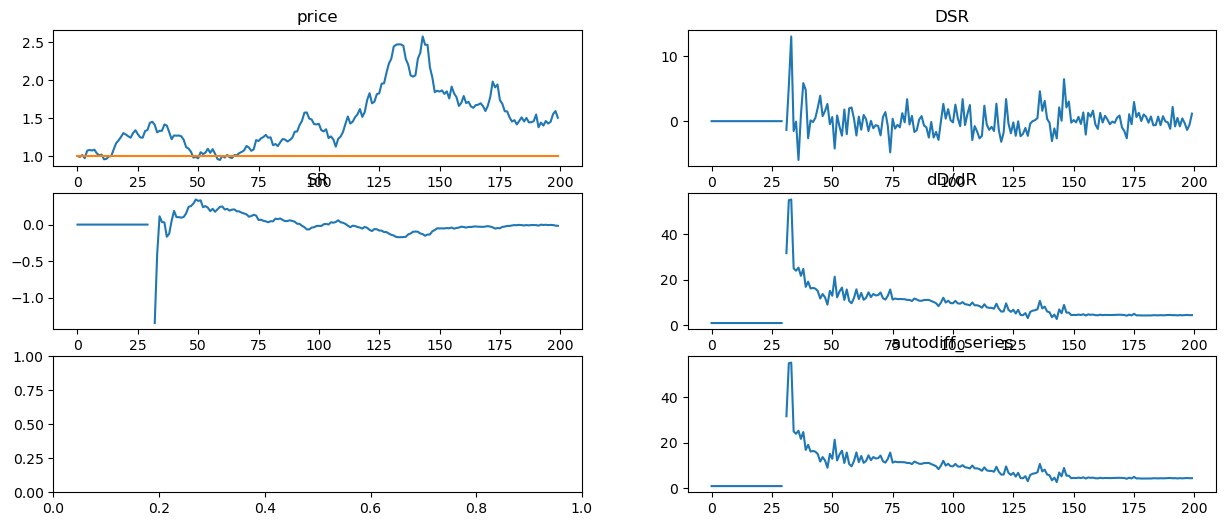

tf.Tensor([[-0.9879356]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9898377]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.99214125]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.99464226]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.99568695]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9966811]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9974555]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9977179]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.99817]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.99847764]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.99842626]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.99876344]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.99880326]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9988157]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9990052]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.99894214]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9990928]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.99912095]], shape=(1, 1), dtype=float32)
tf.

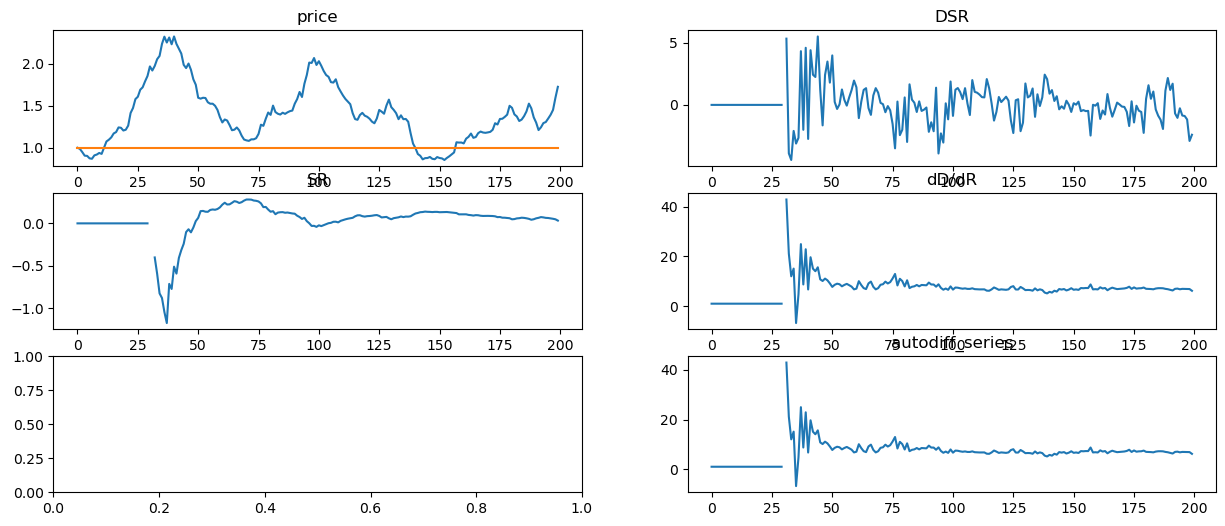

tf.Tensor([[-0.88966715]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8867896]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8777019]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.87814426]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8715897]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8725507]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8713952]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.867616]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8691963]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8674836]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8682389]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.868162]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.87162685]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8690433]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.87487936]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.87692004]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.87681407]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8800756]], shape=(1, 1), dtype=float32)
tf.Ten

KeyboardInterrupt: 

In [9]:
# GENERATION VARS

import time

MU = 3
N = 0.01
RISKFREE_RETURN = 0
TRANS_COST = 0
SERIES_LENGTH = 1000
TRADING_DELAY = 100
K = 3
A = 0.9

EPISODES = 1000

BASELINE_SERIES = gen_price_series(size=SERIES_LENGTH, k=K, a=A)

for ep in range(EPISODES):

    # generate price series
    zt = gen_price_series(size=SERIES_LENGTH, k=K, a=A)
    rt = calc_price_returns(zt)
    Ft = np.zeros((SERIES_LENGTH,))

    # breaks if init at one; MUST INIT ZERO
    At = np.zeros((SERIES_LENGTH,))
    Bt = np.zeros((SERIES_LENGTH,))

    SR_series = np.zeros((SERIES_LENGTH,))
    DSR_series = np.zeros((SERIES_LENGTH,))
    Rt_series = np.zeros((SERIES_LENGTH,))
    dD_series = np.ones((SERIES_LENGTH,))
    autodiff_series = np.ones((SERIES_LENGTH,))


    # plt.plot(zt)
    # plt.show()


    for t in range(INPUT_SIZE, SERIES_LENGTH):

        with tf.GradientTape(persistent=True) as tape:
            # prediction, set new position
            F_curr = F_curr_model(zt[t - INPUT_SIZE + 1:t + 1].reshape(1, INPUT_SIZE))
            F_prev = F_prev_model(zt[t - INPUT_SIZE:t].reshape(1, INPUT_SIZE)) # On the first iteration, this does not exist and is not used.
            Ft[t] = F_curr
            # print(F_curr)

            # if the first iteration, F(t-1) does not yet exist so no update can be made.
            # F_prev_model.set_weights(F_curr_model.get_weights())
            # calculate the gradient
            Rt = calc_return(MU, rt[t], F_curr, F_prev)
            dDt_dRt, At[t], Bt[t] = calc_DSR(N, Rt, At[t - 1], Bt[t - 1])
            
            Rt_series[t] = Rt
            SR_series[t] = np.mean(Rt_series[INPUT_SIZE:t]) / np.std(Rt_series[INPUT_SIZE:t])
            DSR = (Bt[t-1] * (Rt - At[t-1]) - (1/2) * (At[t-1] * (Rt ** 2 - Bt[t-1]))) / ((Bt[t-1] - At[t-1] ** 2) ** 1.5)
            DSR_series[t] = (Bt[t-1] * (Rt - At[t-1]) - (1/2) * (At[t-1] * (Rt ** 2 - Bt[t-1]))) / ((Bt[t-1] - At[t-1] ** 2) ** 1.5)
            dD_series[t] = dDt_dRt

        # calculate derivatives.
        dRt_dFcurr = tape.gradient(Rt, F_curr)
        dRt_dFprev = tape.gradient(Rt, F_prev)
        dFcurr_dThetacurr = tape.gradient(F_curr, F_curr_model.trainable_variables)
        dFprev_dThetaprev = tape.gradient(F_prev, F_prev_model.trainable_variables)
        autodiff_series[t] = tape.gradient(DSR, Rt)

        # print(dRt_dFcurr.shape)
        # print(dFcurr_dThetacurr[0].shape)

        # dont update parameters if DSR hasn't stabilized yet
        if t < TRADING_DELAY:
            continue

        # Set F(t-1) to F(t) for the next iteration.
        F_prev_model.set_weights(F_curr_model.get_weights())

        # print(len(F_curr_model.trainable_variables))
        
        if t != INPUT_SIZE:
            # print("\nSAAAAA========================")
            # multiply derivatives together.
            gradient_update = []
            for i in range(len(dFcurr_dThetacurr)):
                grad = dDt_dRt * (dRt_dFcurr * dFcurr_dThetacurr[i] + dRt_dFprev * dFprev_dThetaprev[i])
                grad *= LEARNING_RATE
                # print(grad.shape)

                gradient_update.append(tf.reshape(grad, F_curr_model.trainable_variables[i].shape))


            VERBOSE = False
            if VERBOSE:
                X = -1
                print("\nSAAAAA========================")
                # a = F_curr_model.trainable_variables[X].numpy()
                # print("bias variable:", F_curr_model.trainable_variables[X])
                # print(F_curr_model.trainable_variables[-2])
                # print("grad update:", gradient_update[X])

                # print("grad update:", gradient_update[X].numpy())
                # print("grad update:", gradient_update)
            # if np.isnan(gradient_update[X].numpy()):
            #     dasufgapg = 1

            # F_curr_model.optimizer.apply_gradients(zip(gradient_update, F_curr_model.trainable_variables))

            vars = F_curr_model.trainable_variables
            for i in range(len(vars)):
                vars[i].assign_add(gradient_update[i])

            if VERBOSE:
                # b = F_curr_model.trainable_variables[X].numpy()
                # print("delta:", b - a)
                # print("new bias :", F_curr_model.trainable_variables[X])
                # print("output:", F_curr)
                print("BASELINE output:", F_curr_model(BASELINE_SERIES[-INPUT_SIZE:].reshape(1, INPUT_SIZE)))

    if ep % 1 == 0:
        print("Episode: ", ep)
        # test performance
        deltas, val_series = test_performance(zt, Ft)

        fig, ax = plt.subplots(3, 2, figsize=(15, 6))

        ax[0, 0].plot(zt)
        ax[0, 0].plot(val_series[0])
        ax[0, 0].set_title("price")

        ax[1, 0].plot(SR_series[:])
        ax[1, 0].set_title("SR")
        # plt.plot(rt)
        # plt.show()
        # plt.plot(Ft)
        # plt.show()
        # plt.plot(Rt_series)
        # plt.show()
        ax[0, 1].plot(DSR_series[:])
        ax[0, 1].set_title("DSR")

        ax[1, 1].plot(dD_series[:])
        ax[1, 1].set_title("dD/dR")
        ax[2, 1].plot(autodiff_series[:])
        ax[2, 1].set_title("autodiff_series")
        plt.show()


    # plt.plot(val_series[1])


In [ ]:
zt = gen_price_series(size=SERIES_LENGTH, k=K, a=A)
rt = calc_price_returns(zt)

print(zt[-10:])
print(rt[-10:])